Import Library

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, Dense, LSTM, Dropout
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint


import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Diplom/dataset/train.csv')
valid_translated = pd.read_csv('/content/drive/MyDrive/Diplom/dataset/valid_translated.csv')
valid = pd.read_csv('/content/drive/MyDrive/Diplom/dataset/validation.csv')
test = pd.read_csv('/content/drive/MyDrive/Diplom/dataset/test.csv')

The function supports calculation of recall, precision and f1 score

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


Graphing function

In [ ]:
def visu(history, title='F1 and Accuracy'):
    fig = plt.figure()
    axs = fig.add_axes([0, 0, 1, 1])
    axs.set_title(title)
    axs.plot(history.history['f1_m'], label='F1 train')
    axs.plot(history.history['val_f1_m'], label='F1 valid')
    axs.plot(history.history['accuracy'], label='Accuracy train')
    axs.plot(history.history['val_accuracy'], label='Accuracy valid')
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Percent')
    axs.set_ylim(0, 1)
    axs.legend()
    fig.show()

In [ ]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()
    plt.show()

# Model 1
No normalization, no pretrain embedding

In [ ]:
x_train = np.array(train['comment_text'])
y_train = np.array(train['toxic'])

x_valid = np.array(valid_translated['translated'])
y_valid = np.array(valid['toxic'])

demo_len = 20000
x_train = x_train[:demo_len] 
y_train = y_train[:demo_len]

Padding + to sequence + tokenizer

In [ ]:
token = text.Tokenizer(oov_token='<OOV>')
token.fit_on_texts(list(x_train))

x_train_seq = token.texts_to_sequences(x_train)
x_valid_seq = token.texts_to_sequences(x_valid)

# max_len = max(list([len(x) for x in x_train_seq]))
max_len = 300
word_index = token.word_index

x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_valid_pad = sequence.pad_sequences(x_valid_seq, maxlen=max_len)

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Embedding(len(word_index) + 1, 200, input_length=max_len))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision_m, recall_m, f1_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 200)          11750000  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                16960     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 11,767,025
Trainable params: 11,767,025
Non-trainable params: 0
_________________________________________________________________


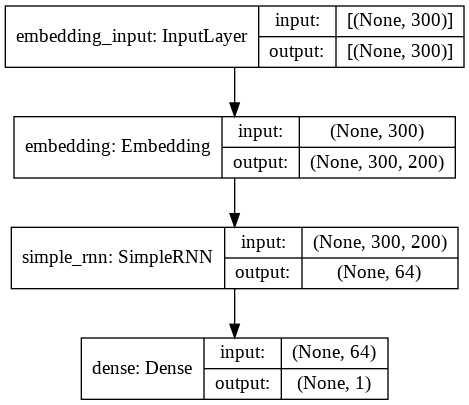

In [ ]:
plot_model(model, show_shapes=True)

Epoch 1/25
79/79 [==============================] - 51s 632ms/step - loss: 0.6788 - accuracy: 0.8954 - precision_m: 0.2579 - recall_m: 0.0755 - f1_m: 0.0930 - val_loss: 1.5245 - val_accuracy: 0.8518 - val_precision_m: 0.6702 - val_recall_m: 0.0813 - val_f1_m: 0.1418

Epoch 00001: val_f1_m improved from -inf to 0.14175, saving model to modelRNN_1.hdf5
Epoch 2/25
79/79 [==============================] - 50s 632ms/step - loss: 0.3247 - accuracy: 0.9425 - precision_m: 0.7677 - recall_m: 0.6300 - f1_m: 0.6752 - val_loss: 1.6621 - val_accuracy: 0.8570 - val_precision_m: 0.7739 - val_recall_m: 0.0842 - val_f1_m: 0.1492

Epoch 00002: val_f1_m improved from 0.14175 to 0.14915, saving model to modelRNN_1.hdf5
Epoch 3/25
79/79 [==============================] - 50s 637ms/step - loss: 0.2457 - accuracy: 0.9504 - precision_m: 0.8967 - recall_m: 0.5884 - f1_m: 0.6732 - val_loss: 1.6809 - val_accuracy: 0.8434 - val_precision_m: 0.3581 - val_recall_m: 0.0307 - val_f1_m: 0.0557

Epoch 00003: val_f1_m d

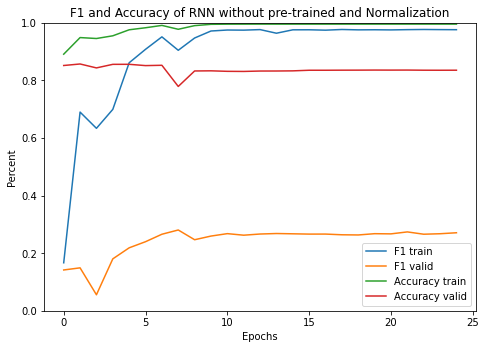

In [ ]:
checkpoint = ModelCheckpoint('modelRNN_1.hdf5', verbose=1, monitor='val_f1_m',save_best_only=True, mode='max')  

history = model.fit(x_train_pad, y_train,
                    callbacks=[checkpoint],
                    validation_data=(x_valid_pad, y_valid),
                    epochs=25, verbose=1, batch_size=256)
  
visu(history, 'F1 and Accuracy of RNN without pre-trained and Normalization')

model.load_weights('modelRNN_1.hdf5')
y_valid_pred = model.predict(x_valid_pad) >= 0.5

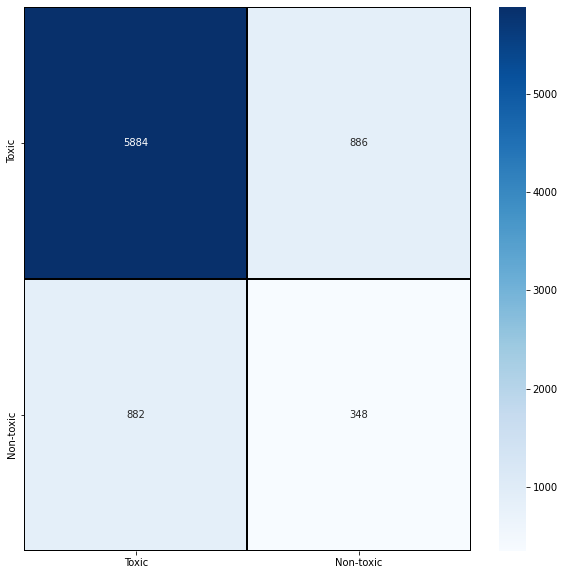

In [ ]:
cm = confusion_matrix(y_valid, y_valid_pred)
cm = pd.DataFrame(cm, index = ['Toxic','Non-toxic'] , columns = ['Toxic','Non-toxic'])

plt.figure(figsize = (10, 10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Toxic','Non-toxic'] , yticklabels = ['Toxic','Non-toxic'])

plt.show()

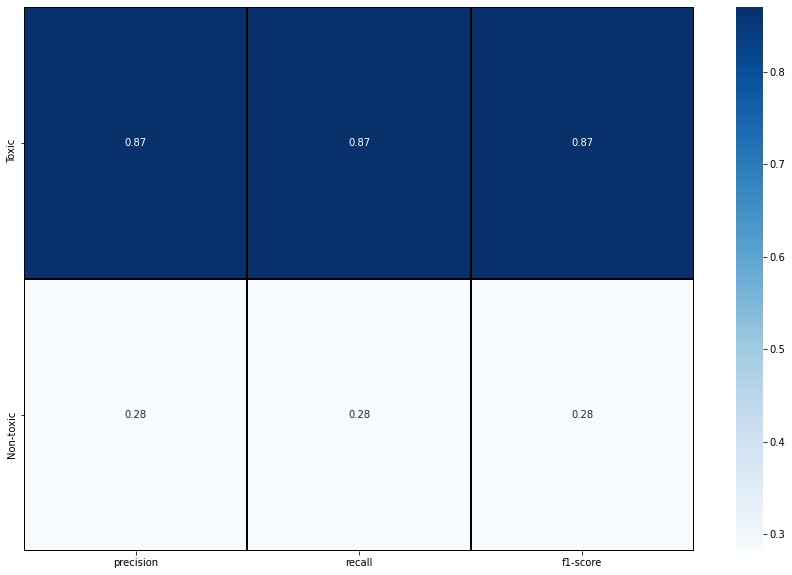

In [ ]:
cr = classification_report(y_valid, y_valid_pred, target_names=['Toxic','Non-toxic'], output_dict=True)
plt.figure(figsize = (15, 10))
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :-3].T, cmap= "Blues", linecolor = 'black', linewidth = 1, annot=True)
plt.show()

# Model 2

Using pre-trained models (GloVe)

In [ ]:
x_train = np.array(train['comment_text'])
y_train = np.array(train['toxic'])

x_valid = np.array(valid_translated['translated'])
y_valid = np.array(valid['toxic'])

demo_len = 20000
x_train = x_train[:demo_len] 
y_train = y_train[:demo_len]

Padding + to sequence + tokenizer

In [ ]:
token = text.Tokenizer(oov_token='<OOV>')
token.fit_on_texts(list(x_train))

x_train_seq = token.texts_to_sequences(x_train)
x_valid_seq = token.texts_to_sequences(x_valid)

# max_len = max(list([len(x) for x in x_train_seq]))
max_len = 300
word_index = token.word_index

x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_valid_pad = sequence.pad_sequences(x_valid_seq, maxlen=max_len)

Add pre-trained model GloVe

In [ ]:
#Add GloVe
GloVe = {}
for line in open('/content/drive/MyDrive/Diplom/GloVe/glove.twitter.27B.200d.txt', encoding="utf8"):
    split = line.split()
    word = split[0]
    vector = [float(x) for x in split[1:]]
    GloVe[word] = np.array(vector)


In [ ]:
#Transform to embedding matrix
embedding_matrix = np.zeros((len(word_index)+1, 200))
for item in word_index.items():
    word = item[0]
    i = item[1]
    if GloVe.get(word) is not None:
        embedding_matrix[i] = GloVe[word]

Model building (using non-trainable embedding matrix)

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Embedding(len(word_index) + 1, 200, 
                    weights = [embedding_matrix],
                    trainable = False,
                    input_length=max_len))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision_m, recall_m, f1_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 200)          11750000  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                16960     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 11,767,025
Trainable params: 17,025
Non-trainable params: 11,750,000
_________________________________________________________________


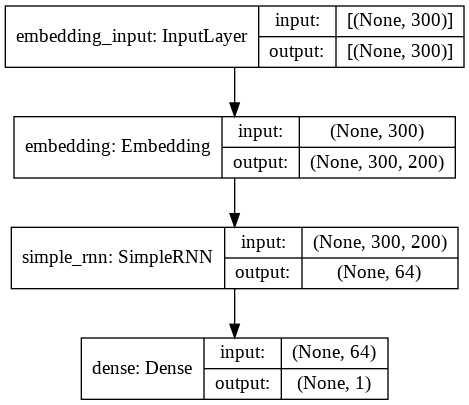

In [ ]:
plot_model(model, show_shapes=True)

Epoch 1/25
10/10 [==============================] - 47s 4s/step - loss: 5.4599 - accuracy: 0.4822 - precision_m: 0.1186 - recall_m: 0.6221 - f1_m: 0.1906 - val_loss: 1.9390 - val_accuracy: 0.7747 - val_precision_m: 0.2241 - val_recall_m: 0.1885 - val_f1_m: 0.2046

Epoch 00001: val_f1_m improved from -inf to 0.20464, saving model to modelRNN_2.hdf5
Epoch 2/25
10/10 [==============================] - 34s 3s/step - loss: 1.4121 - accuracy: 0.8005 - precision_m: 0.1724 - recall_m: 0.2541 - f1_m: 0.2045 - val_loss: 1.9859 - val_accuracy: 0.8165 - val_precision_m: 0.2496 - val_recall_m: 0.0965 - val_f1_m: 0.1390

Epoch 00002: val_f1_m did not improve from 0.20464
Epoch 3/25
10/10 [==============================] - 33s 3s/step - loss: 1.2944 - accuracy: 0.8645 - precision_m: 0.2044 - recall_m: 0.1319 - f1_m: 0.1586 - val_loss: 2.0974 - val_accuracy: 0.8353 - val_precision_m: 0.2552 - val_recall_m: 0.0379 - val_f1_m: 0.0659

Epoch 00003: val_f1_m did not improve from 0.20464
Epoch 4/25
10/10 [

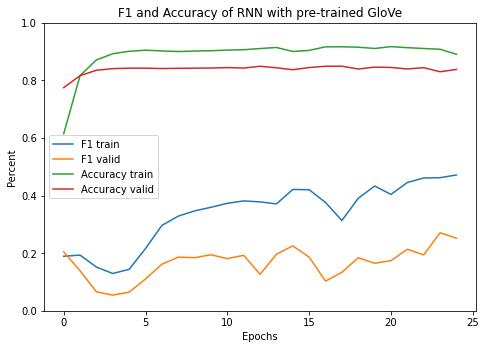

In [ ]:
checkpoint = ModelCheckpoint('modelRNN_2.hdf5', verbose=1, monitor='val_f1_m',save_best_only=True, mode='max')  

history = model.fit(x_train_pad, y_train,
                    callbacks=[checkpoint],
                    validation_data=(x_valid_pad, y_valid),
                    epochs=25, verbose=1, batch_size=256)
  
visu(history, 'F1 and Accuracy of RNN with pre-trained GloVe')

model.load_weights('modelRNN_2.hdf5')
y_valid_pred = model.predict(x_valid_pad) >= 0.5

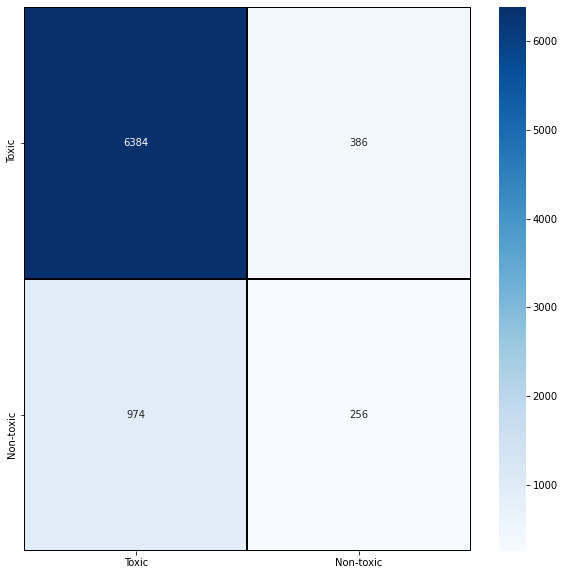

In [ ]:
cm = confusion_matrix(y_valid, y_valid_pred)
cm = pd.DataFrame(cm, index = ['Toxic','Non-toxic'] , columns = ['Toxic','Non-toxic'])

plt.figure(figsize = (10, 10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Toxic','Non-toxic'] , yticklabels = ['Toxic','Non-toxic'])

plt.show()

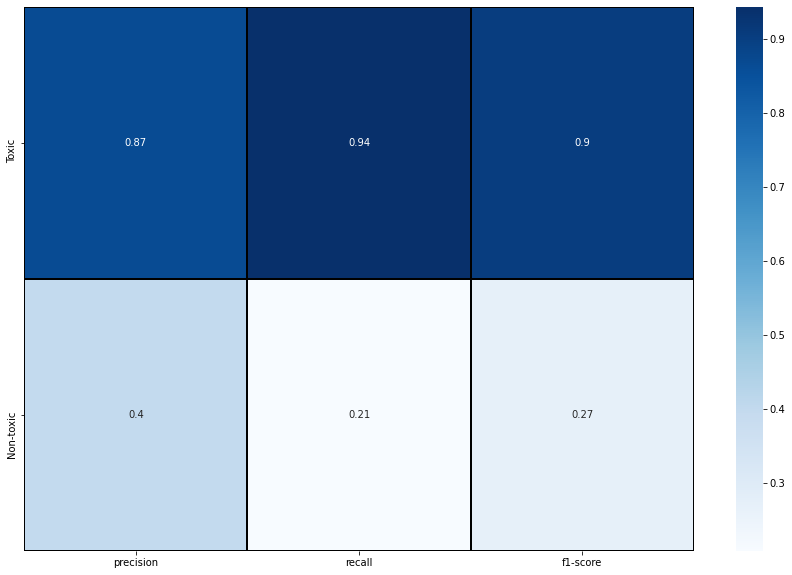

In [ ]:
cr = classification_report(y_valid, y_valid_pred, target_names=['Toxic','Non-toxic'], output_dict=True)
plt.figure(figsize = (15, 10))
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :-3].T, cmap= "Blues", linecolor = 'black', linewidth = 1, annot=True)
plt.show()

# Model 3
Using normalization

In [ ]:
x_train = np.array(train['comment_text'])
y_train = np.array(train['toxic'])

x_valid = np.array(valid_translated['translated'])
y_valid = np.array(valid['toxic'])

demo_len = 20000
x_train = x_train[:demo_len] 
y_train = y_train[:demo_len]

Data cleaning

In [ ]:
def to_lower_case(text):
    return text.lower()
# to_lower_case('Kim Jong-un Dead?')

In [ ]:
def remove_URLs(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)
# remove_URLs('Vietnam has reported no coronavirus deaths – how?: https://theconversation.com/vietnam-has-reported-no-coronavirus-deaths-how-136646')

In [ ]:
def remove_HTMLs(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)
# remove_HTMLs('The <strong>UFOs</strong> have been found')

In [ ]:
def remove_annotations(text):
    annotation = re.compile(r'\[[^]]*\]')
    return annotation.sub(r'', text)
# remove_annotations('People in Vietnam try black cat paste to ward off coronavirus [Daily News]')

In [ ]:
def remove_punctuations(text):
    punctuation = re.compile(r'[^a-zA-Z0-9]+')
    return punctuation.sub(r' ', text)
# remove_punctuations('FBI Russia probe helped by Australian diplomat tip-off: NYT.')

In [ ]:
stop_words_list = set(stopwords.words('english'))

def remove_stopwords(text):
    text = text.split()
    text = [word for word in text if word not in stop_words_list]
    return ' '.join(text)
# remove_stopwords("People in Vietnam try black cat paste to ward off coronavirus!")

In [ ]:
lemmatizer = WordNetLemmatizer()

def pos_recognition(tag):
    if (tag[0] == 'J'):
        return 'a'
    if (tag[0] == 'N'):
        return 'n'
    if (tag[0] == 'R'):
        return 'r'
    if (tag[0] == 'V'):
        return 'v'
    return ''

def lemmatization(text):
    text = nltk.pos_tag(text.split())
    for i in range(len(text)):
        if (pos_recognition(text[i][1]) != ''):
            text[i] = lemmatizer.lemmatize(text[i][0], pos = pos_recognition(text[i][1]))
        else:
            text[i] = lemmatizer.lemmatize(text[i][0])
    return ' '.join(text)
# lemmatization('Coronavirus is continuing its spread across the world with more than three and a half million confirmed cases in 187 countries')

In [ ]:
def data_clean(x):
  x = to_lower_case(x)
  x = remove_URLs(x)
  x = remove_HTMLs(x)
  x = remove_annotations(x)
  x = remove_punctuations(x)
  x = remove_stopwords(x)
  x = lemmatization(x)
  x = x.replace('  ', ' ')
  return x

In [ ]:
print('Before normalization')
print(x_train[:5])
print(x_valid[:5])

Before normalization
["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 '"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for for

In [ ]:
x_train = [data_clean(x) for x in x_train]
x_valid = [data_clean(x) for x in x_valid]

In [ ]:
print('After normalization')
print(x_train[:5])
print(x_valid[:5])

After normalization
['explanation edits make username hardcore metallica fan revert vandalisms closure gas vote new york doll fac please remove template talk page since retire 89 205 38 27', 'aww match background colour seemingly stuck thanks talk 21 51 january 11 2016 utc', 'hey man really try edit war guy constantly remove relevant information talk edits instead talk page seem care format actual info', 'make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidy exact format ie date format etc later one else first preference format style reference want please let know appear backlog article review guess may delay reviewer turn list relevant form eg wikipedia good article nomination transport', 'sir hero chance remember page']
['user even rise rank heretic therefore burn barbecue purify soul digestive system ingestion skipe linkin 22px honor courage loyalty 17 48 march 13 2008 utc', 'text entry seem copy directly guess may cop

Padding + to sequence + tokenizer

In [ ]:
token = text.Tokenizer(oov_token='<OOV>')
token.fit_on_texts(list(x_train))

x_train_seq = token.texts_to_sequences(x_train)
x_valid_seq = token.texts_to_sequences(x_valid)

# max_len = max(list([len(x) for x in x_train_seq]))
max_len = 300
word_index = token.word_index

x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_valid_pad = sequence.pad_sequences(x_valid_seq, maxlen=max_len)

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Embedding(len(word_index) + 1, 200, input_length=max_len))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision_m, recall_m, f1_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 200)          9184400   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                16960     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 9,201,425
Trainable params: 9,201,425
Non-trainable params: 0
_________________________________________________________________


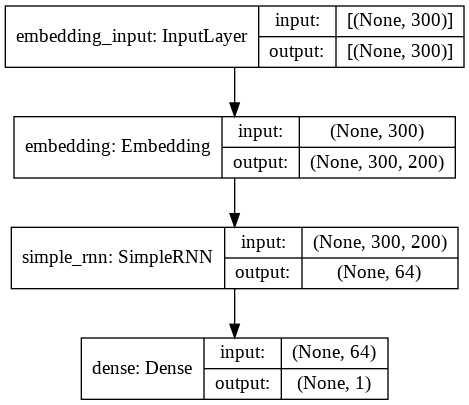

In [ ]:
plot_model(model, show_shapes=True)

Epoch 1/25
79/79 [==============================] - 49s 603ms/step - loss: 0.5081 - accuracy: 0.8959 - precision_m: 0.2757 - recall_m: 0.0563 - f1_m: 0.0779 - val_loss: 0.5188 - val_accuracy: 0.8015 - val_precision_m: 0.3016 - val_recall_m: 0.2156 - val_f1_m: 0.2467

Epoch 00001: val_f1_m improved from -inf to 0.24670, saving model to modelRNN_3.hdf5
Epoch 2/25
79/79 [==============================] - 47s 600ms/step - loss: 0.2263 - accuracy: 0.9474 - precision_m: 0.9767 - recall_m: 0.4787 - f1_m: 0.6205 - val_loss: 1.1593 - val_accuracy: 0.8418 - val_precision_m: 0.4219 - val_recall_m: 0.0944 - val_f1_m: 0.1512

Epoch 00002: val_f1_m did not improve from 0.24670
Epoch 3/25
79/79 [==============================] - 47s 596ms/step - loss: 0.1418 - accuracy: 0.9835 - precision_m: 0.9918 - recall_m: 0.8465 - f1_m: 0.9118 - val_loss: 1.3295 - val_accuracy: 0.8432 - val_precision_m: 0.4470 - val_recall_m: 0.1229 - val_f1_m: 0.1889

Epoch 00003: val_f1_m did not improve from 0.24670
Epoch 4/2

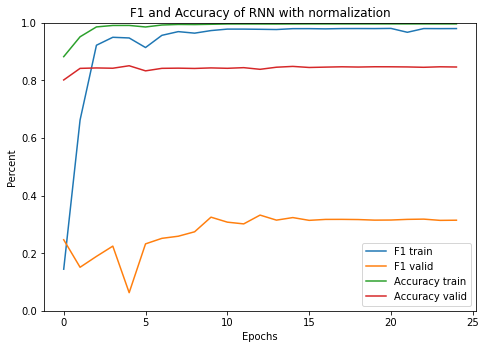

In [ ]:
checkpoint = ModelCheckpoint('modelRNN_3.hdf5', verbose=1, monitor='val_f1_m',save_best_only=True, mode='max')  

history = model.fit(x_train_pad, y_train,
                    callbacks=[checkpoint],
                    validation_data=(x_valid_pad, y_valid),
                    epochs=25, verbose=1, batch_size=256)
  
visu(history, 'F1 and Accuracy of RNN with normalization')
model.load_weights('modelRNN_3.hdf5')
y_valid_pred = model.predict(x_valid_pad) >= 0.5

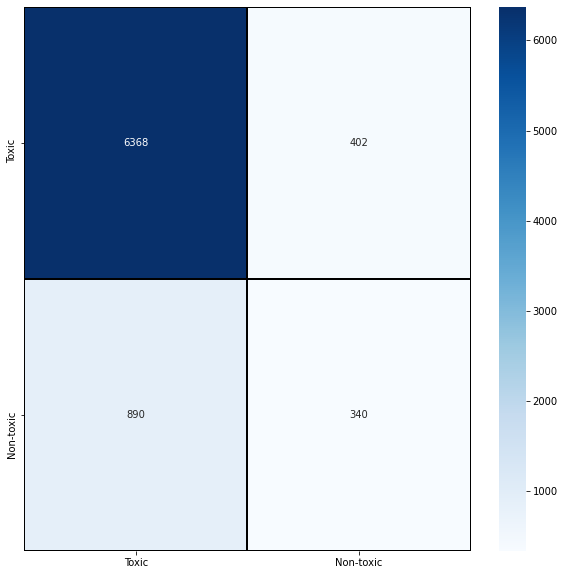

In [ ]:
cm = confusion_matrix(y_valid, y_valid_pred)
cm = pd.DataFrame(cm, index = ['Toxic','Non-toxic'] , columns = ['Toxic','Non-toxic'])

plt.figure(figsize = (10, 10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Toxic','Non-toxic'] , yticklabels = ['Toxic','Non-toxic'])

plt.show()

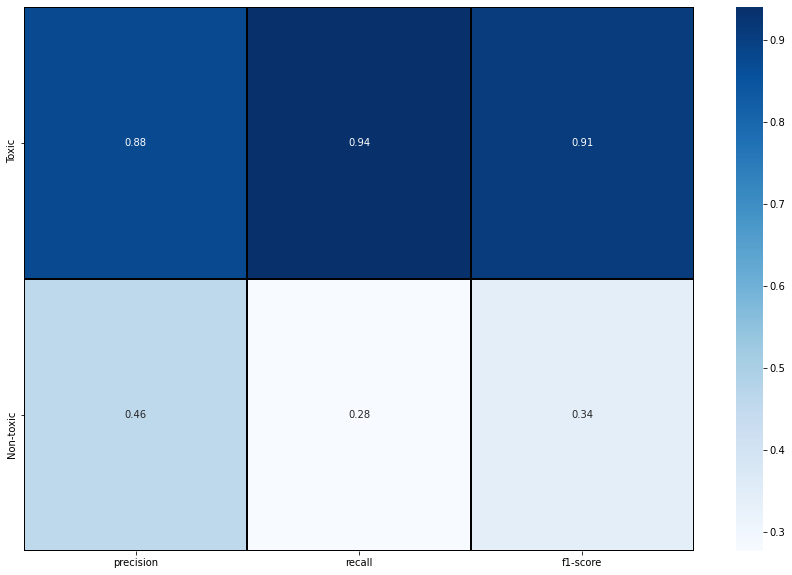

In [ ]:
cr = classification_report(y_valid, y_valid_pred, target_names=['Toxic','Non-toxic'], output_dict=True)
plt.figure(figsize = (15, 10))
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :-3].T, cmap= "Blues", linecolor = 'black', linewidth = 1, annot=True)
plt.show()

# Model 4
Using a combination of pre-trained models and normalization

In [ ]:
x_train = np.array(train['comment_text'])
y_train = np.array(train['toxic'])

x_valid = np.array(valid_translated['translated'])
y_valid = np.array(valid['toxic'])

demo_len = 20000
x_train = x_train[:demo_len] 
y_train = y_train[:demo_len]

Data cleaning

In [ ]:
x_train = [data_clean(x) for x in x_train]
x_valid = [data_clean(x) for x in x_valid]

Padding + to sequence + tokenizer

In [ ]:
token = text.Tokenizer(oov_token='<OOV>')
token.fit_on_texts(list(x_train))

x_train_seq = token.texts_to_sequences(x_train)
x_valid_seq = token.texts_to_sequences(x_valid)

# max_len = max(list([len(x) for x in x_train_seq]))
max_len = 300
word_index = token.word_index

x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_valid_pad = sequence.pad_sequences(x_valid_seq, maxlen=max_len)

Add pre-trained model

In [ ]:
#Transform to embedding matrix
embedding_matrix = np.zeros((len(word_index)+1, 200))
for item in word_index.items():
    word = item[0]
    i = item[1]
    if GloVe.get(word) is not None:
        embedding_matrix[i] = GloVe[word]

Model building (using non-trainable embedding matrix)

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Embedding(len(word_index) + 1, 200, 
                    weights = [embedding_matrix],
                    trainable = False,
                    input_length=max_len))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision_m, recall_m, f1_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 200)          9184400   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                16960     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 9,201,425
Trainable params: 17,025
Non-trainable params: 9,184,400
_________________________________________________________________


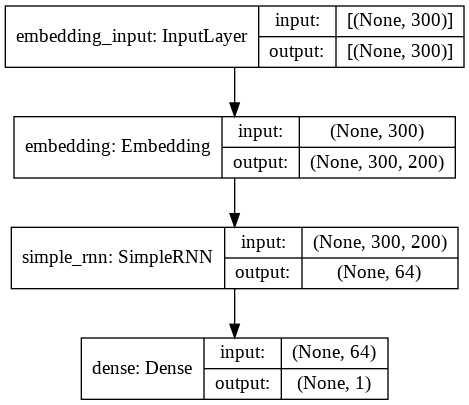

In [ ]:
plot_model(model, show_shapes=True)

Epoch 1/25
79/79 [==============================] - 31s 382ms/step - loss: 1.2223 - accuracy: 0.8795 - precision_m: 0.3349 - recall_m: 0.1347 - f1_m: 0.1727 - val_loss: 1.7054 - val_accuracy: 0.8389 - val_precision_m: 0.4429 - val_recall_m: 0.1864 - val_f1_m: 0.2589

Epoch 00001: val_f1_m improved from -inf to 0.25893, saving model to modelRNN_4.hdf5
Epoch 2/25
79/79 [==============================] - 30s 386ms/step - loss: 0.8614 - accuracy: 0.9094 - precision_m: 0.5604 - recall_m: 0.3858 - f1_m: 0.4452 - val_loss: 1.8507 - val_accuracy: 0.8518 - val_precision_m: 0.5633 - val_recall_m: 0.1425 - val_f1_m: 0.2248

Epoch 00002: val_f1_m did not improve from 0.25893
Epoch 3/25
79/79 [==============================] - 30s 384ms/step - loss: 0.8273 - accuracy: 0.9204 - precision_m: 0.6813 - recall_m: 0.3930 - f1_m: 0.4888 - val_loss: 1.9044 - val_accuracy: 0.7680 - val_precision_m: 0.3150 - val_recall_m: 0.4432 - val_f1_m: 0.3637

Epoch 00003: val_f1_m improved from 0.25893 to 0.36372, savi

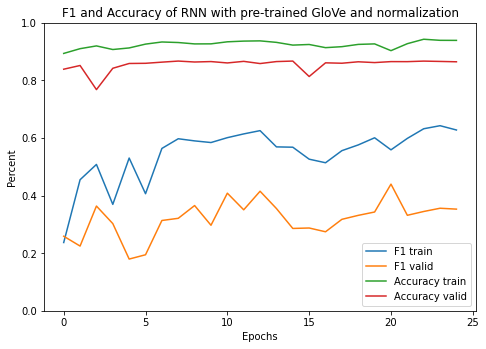

In [ ]:
checkpoint = ModelCheckpoint('modelRNN_4.hdf5', verbose=1, monitor='val_f1_m',save_best_only=True, mode='max')  

history = model.fit(x_train_pad, y_train,
                    callbacks=[checkpoint],
                    validation_data=(x_valid_pad, y_valid),
                    epochs=25, verbose=1, batch_size=256)
  
visu(history, 'F1 and Accuracy of RNN with pre-trained GloVe and normalization')

model.load_weights('modelRNN_4.hdf5')
y_valid_pred = model.predict(x_valid_pad) >= 0.5

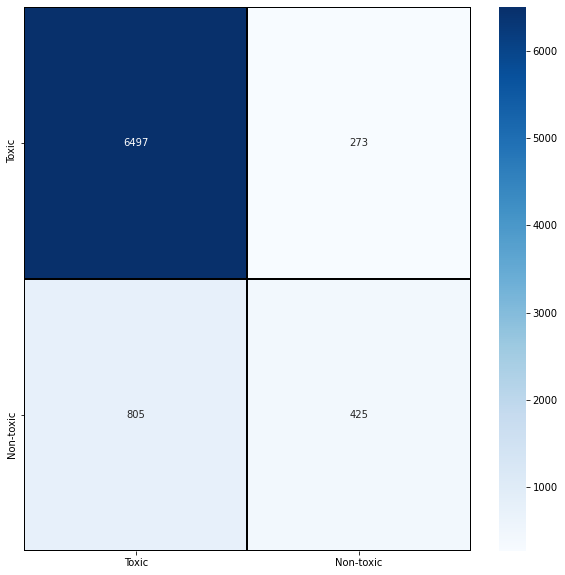

In [ ]:
cm = confusion_matrix(y_valid, y_valid_pred)
cm = pd.DataFrame(cm, index = ['Toxic','Non-toxic'] , columns = ['Toxic','Non-toxic'])

plt.figure(figsize = (10, 10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Toxic','Non-toxic'] , yticklabels = ['Toxic','Non-toxic'])

plt.show()

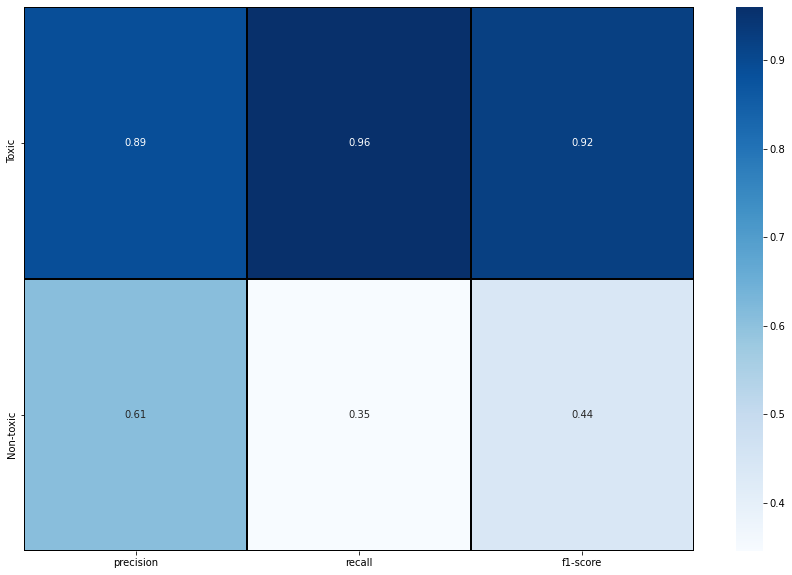

In [ ]:
cr = classification_report(y_valid, y_valid_pred, target_names=['Toxic','Non-toxic'], output_dict=True)
plt.figure(figsize = (15, 10))
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :-3].T, cmap= "Blues", linecolor = 'black', linewidth = 1, annot=True)
plt.show()